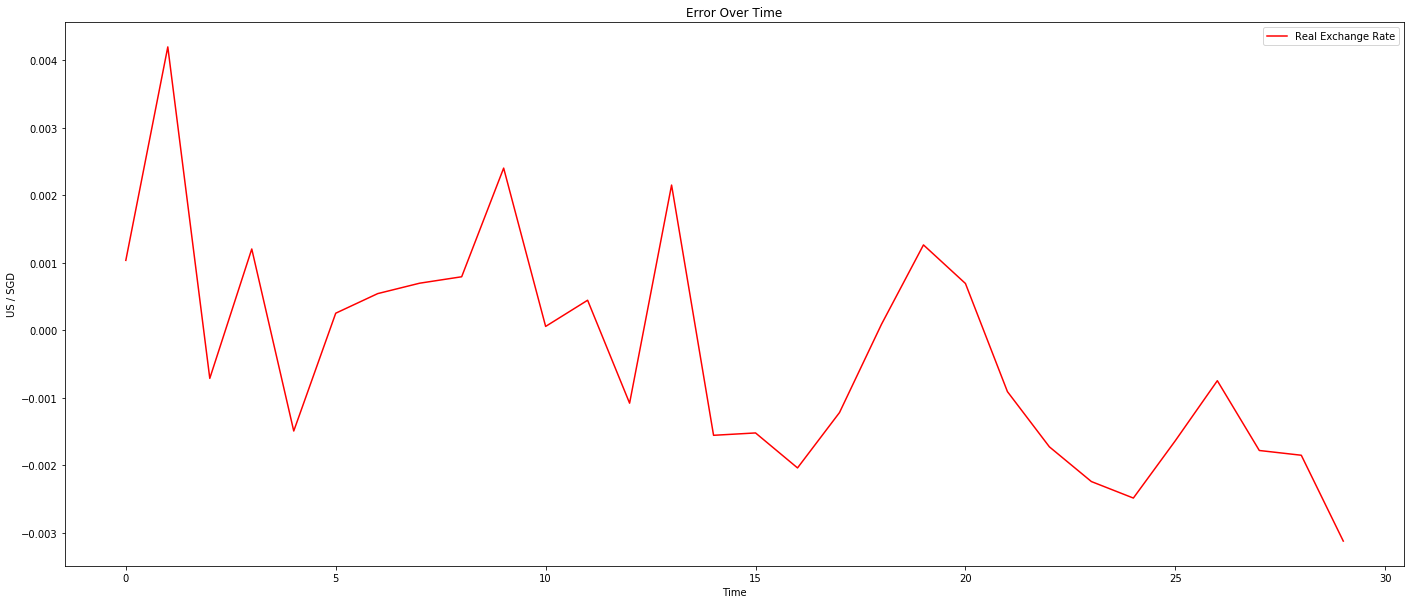

In [39]:
# Error Analysis

error=predicted_rate-real_rate
# Visualising the results
import matplotlib.pyplot as plt
plt.figure(figsize=(24,10))
plt.plot(error, color = 'red', label = 'Real Exchange Rate')
plt.title('Error Over Time')
plt.xlabel('Time')
plt.ylabel('US / SGD')
plt.legend()
plt.show()

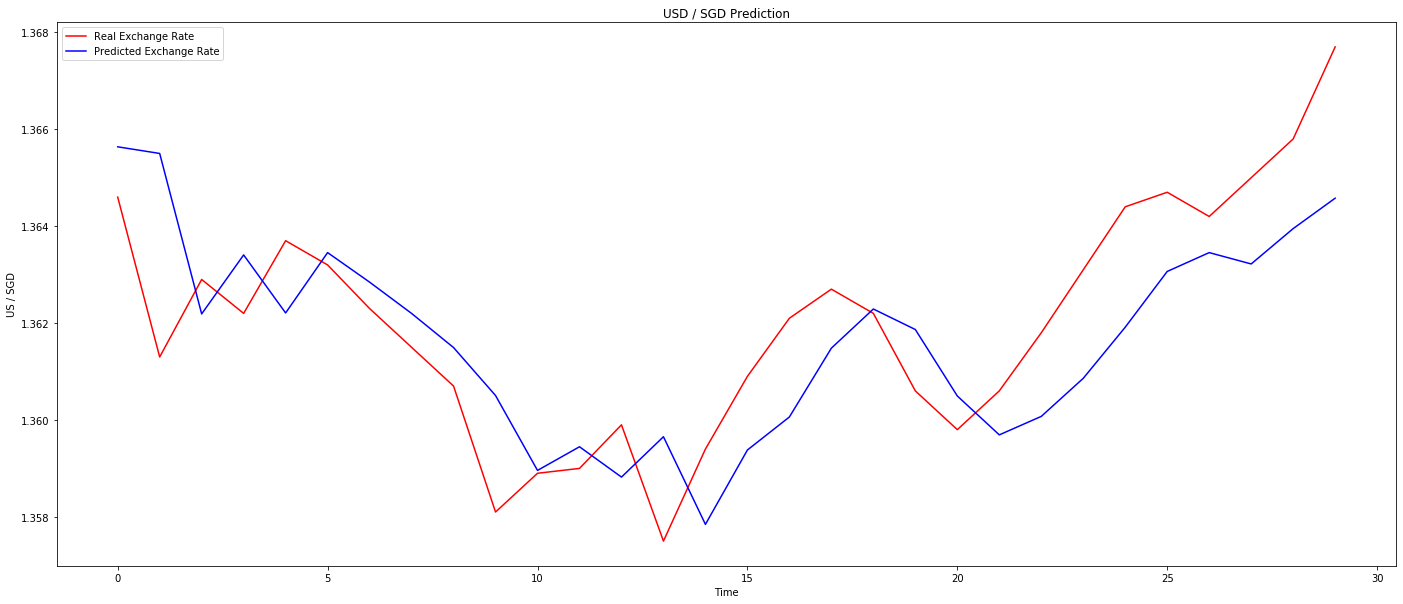

In [35]:
# Part 2: Interpreting Model Results

# Visualising the results
import matplotlib.pyplot as plt
plt.figure(figsize=(24,10))
plt.plot(real_rate, color = 'red', label = 'Real Exchange Rate')
plt.plot(predicted_rate, color = 'blue', label = 'Predicted Exchange Rate')
plt.title('USD / SGD Prediction')
plt.xlabel('Time')
plt.ylabel('US / SGD')
plt.legend()
plt.show()




In [46]:
## Part 1: Model Building and Results

import pandas as pd
import numpy as np
DFF=pd.read_csv("DFF.csv")
DFF["DATE"]=pd.to_datetime(DFF["DATE"])
ER=pd.read_csv("us-dollar-singapore-exchange-rate-historical-chart.csv")[3:]
ER.columns = ['Date', 'ER']
ER['Date']=pd.to_datetime(ER["Date"])
SIBOR=pd.read_csv("SIBOR.csv").iloc[:,:2]
SIBOR["SIBOR DATE"]=pd.to_datetime(SIBOR["SIBOR DATE"])
data=pd.merge(ER,SIBOR , left_on='Date', right_on='SIBOR DATE',how='inner')
data=pd.merge(data,DFF , left_on='Date', right_on='DATE',how='inner')
data=data.drop(columns=['SIBOR DATE', 'DATE'])
data['ER']=pd.to_numeric(data['ER'])
dataset_train=data.iloc[:-30,:] # Set test set size of 30
dataset_test=data.iloc[-30:,:] # Set test set size of 30
training_set = dataset_train.iloc[:, 1:4].values # Selecting the relevant columns 

# Feature Scaling to normalise the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a matrix based on 60 timesteps. Hence, the model is trained on n-60th day exchange rate to predict the nth day's rate
X_train = []
y_train = []
time_steps=60
for i in range(time_steps, len(dataset_train.index)): 
    X_train.append(training_set_scaled[i-time_steps:i,:3]) 
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping the data 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))

# Building the RNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error
from math import sqrt

regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation.
regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 3)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2)) # 0.2 is a good number to use

# Adding a third LSTM layer and some Dropout regularisation. 
regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set. Can change the number of epochs  and batch size 

regressor.fit(X_train, y_train, epochs = 1, batch_size = 32)

# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
real_rate = dataset_test.iloc[:, 1:2].values

dataset_total = pd.concat((dataset_train.iloc[:,1:4], dataset_test.iloc[:,1:4]), axis = 0) 
inputs = np.array(dataset_total.iloc[len(dataset_total) - len(dataset_test) - time_steps:,:3])
inputs = inputs.reshape(-1,3)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps,len(dataset_test.index)+time_steps): 
    X_test.append(inputs[i-time_steps:i, 0:3])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))
predicted_rate = regressor.predict(X_test)
sc.fit_transform(training_set[:,0:1])
predicted_rate=sc.inverse_transform(predicted_rate)
real_rate=real_rate.astype(np.float)
Mean_Deviation=sqrt(mean_squared_error(predicted_rate, real_rate))/np.mean(real_rate)*100
print("Mean deviation from actual exchange rate is "+str(round(Mean_Deviation, 3))+"%")

Epoch 1/1
1380/1380 [==============================] - 7s 5ms/step - loss: 0.0373
Mean deviation from actual exchange rate is 0.436%
